## Data Reading and Preprocessing

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

In [121]:
data=pd.read_csv('heart.csv')

In [122]:
display(data.size)
display(data.shape)
display(data.info())
display(data.head())

14350

(1025, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [123]:
print("NAN")
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])

print("\nNULL")
null_counts = data.isnull().sum()
print(null_counts[null_counts > 0])

NAN
Series([], dtype: int64)

NULL
Series([], dtype: int64)


In [124]:
numeric_data=data.select_dtypes(exclude=['object']).columns
print("Numerical Features:",len(list(numeric_data)),"\n",list(numeric_data))
categorical_data=data.select_dtypes(include=['object']).columns
print("Categorial Features:",len(list(categorical_data)),"\n",list(categorical_data))

Numerical Features: 14 
 ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Categorial Features: 0 
 []


In [125]:
for col in data.select_dtypes(include=['object']):
        data[col] = data[col].str.lower().str.strip()

In [126]:
def remove_outliers(data):
    df_clean = data.copy()
    initial_rows = len(df_clean)
    
    for col in df_clean.select_dtypes(exclude=['object']).columns:
        Q1 = df_clean[col].quantile(0.15)
        Q3 = df_clean[col].quantile(0.85)
        IQR = Q3 - Q1
        df_clean = df_clean[(df_clean[col] >= Q1 - 1.5 * IQR) & 
                           (df_clean[col] <= Q3 + 1.5 * IQR)]
    
    removed = initial_rows - len(df_clean)
    display(f"Removed {removed} outliers ({removed/initial_rows:.2%} of data)")
    return df_clean


data = remove_outliers(data)

'Removed 162 outliers (15.80% of data)'

In [127]:
def z_score_outliers(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return z_scores > threshold

outliers_dict = {}
for col in numeric_data:
    mask = z_score_outliers(data[col])
    outliers_dict[col] = data[mask].shape[0]

combined_mask = pd.DataFrame({col: z_score_outliers(data[col]) for col in numeric_data})
any_outlier = combined_mask.any(axis=1)
total_outliers = any_outlier.sum()
outlier_percentage = (total_outliers / len(data)) * 100
display(f"Removed: {total_outliers} outliers ({outlier_percentage:.2f}%) of data")

'Removed: 36 outliers (4.17%) of data'

In [128]:
from sklearn.ensemble import IsolationForest

def isolation_forest_outliers(data):
    data_cleaned = data.copy()    
    outlier_masks = {}
    
    for col in data.select_dtypes(exclude=['object']).columns:
        column_data = data[col].values.reshape(-1, 1)
        clf = IsolationForest(
            n_estimators=200,
            max_samples=0.7,
            contamination=0.005,
            random_state=1
        )
        preds = clf.fit_predict(column_data)
        outlier_masks[col] = pd.Series((preds == -1), index=data.index)

    combined_mask = pd.DataFrame(outlier_masks, index=data.index)
    rows_with_outliers = combined_mask.any(axis=1)

    data_cleaned = data_cleaned.loc[~rows_with_outliers]

    outlier_count = rows_with_outliers.sum()
    outlier_percent = (outlier_count / len(data)) * 100
    print(f"Removed {outlier_count} outliers ({outlier_percent:.2f}% of data)")

    for col in outlier_masks:
        col_outliers = outlier_masks[col].sum()
    
    return data_cleaned

data = isolation_forest_outliers(data)

Removed 18 outliers (2.09% of data)


In [129]:
for col in data.select_dtypes(include=['object']).columns:
    display(data[col].value_counts())

In [130]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col]=encoder.fit_transform(data[col])

In [131]:
from sklearn.preprocessing import StandardScaler
def scaled_data(data):
    data_copy = data.copy()
    scaler = StandardScaler()
    data_copy[numeric_data] = scaler.fit_transform(data_copy[numeric_data]) 
    return data_copy
scalled_data= scaled_data(data)

<Axes: >

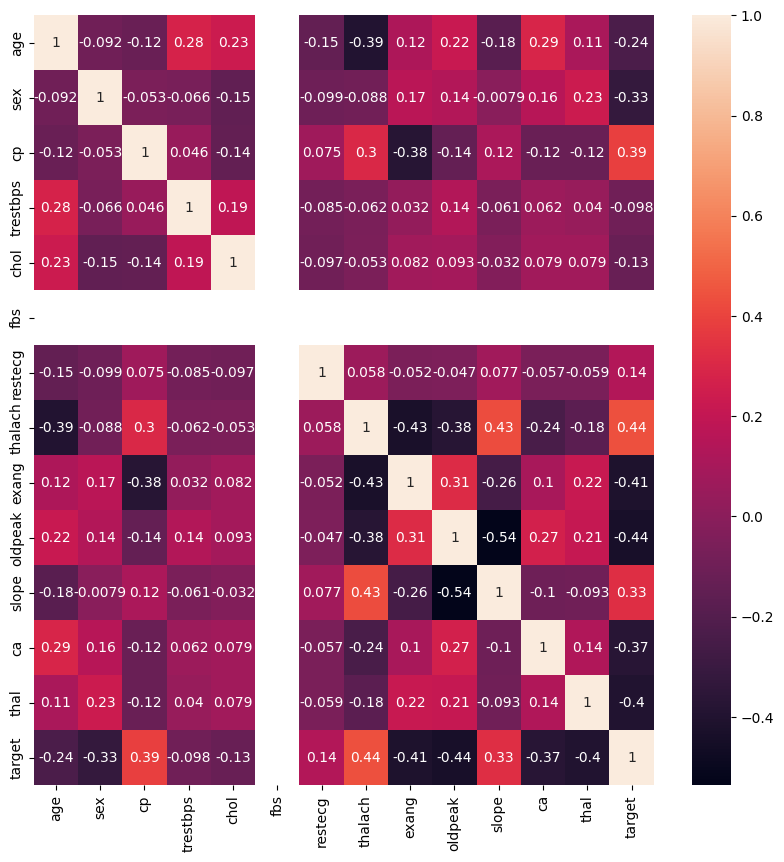

In [132]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)

In [133]:
x=scalled_data.iloc[:,:-1]
y=data.iloc[:,-1]

Logistic Regression Accuracy: 0.8071
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       123
           1       0.82      0.80      0.81       131

    accuracy                           0.81       254
   macro avg       0.81      0.81      0.81       254
weighted avg       0.81      0.81      0.81       254

Naive Bayes Accuracy: 0.8268
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       123
           1       0.86      0.79      0.83       131

    accuracy                           0.83       254
   macro avg       0.83      0.83      0.83       254
weighted avg       0.83      0.83      0.83       254

Decision Tree Accuracy: 0.9724
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       123
           1       0.97      0.98      0.97       131

    accuracy                           0.97       254
   macro avg       0.97      0.

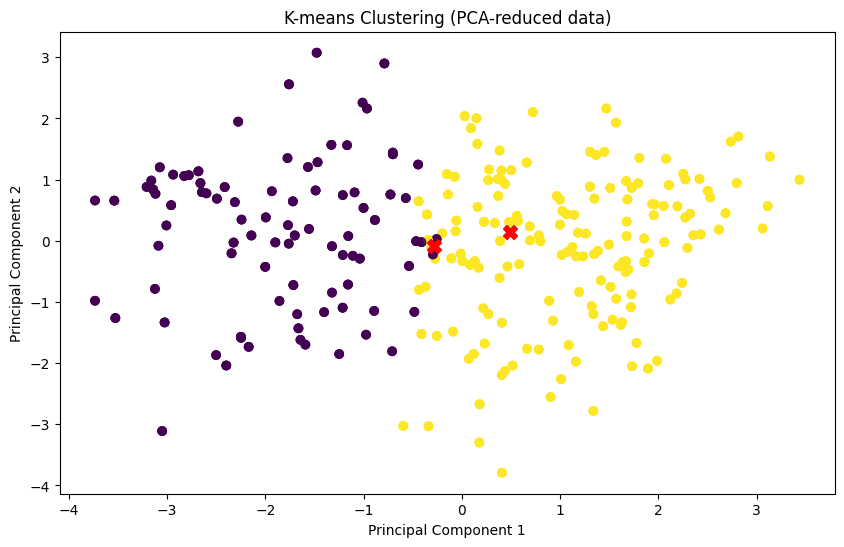

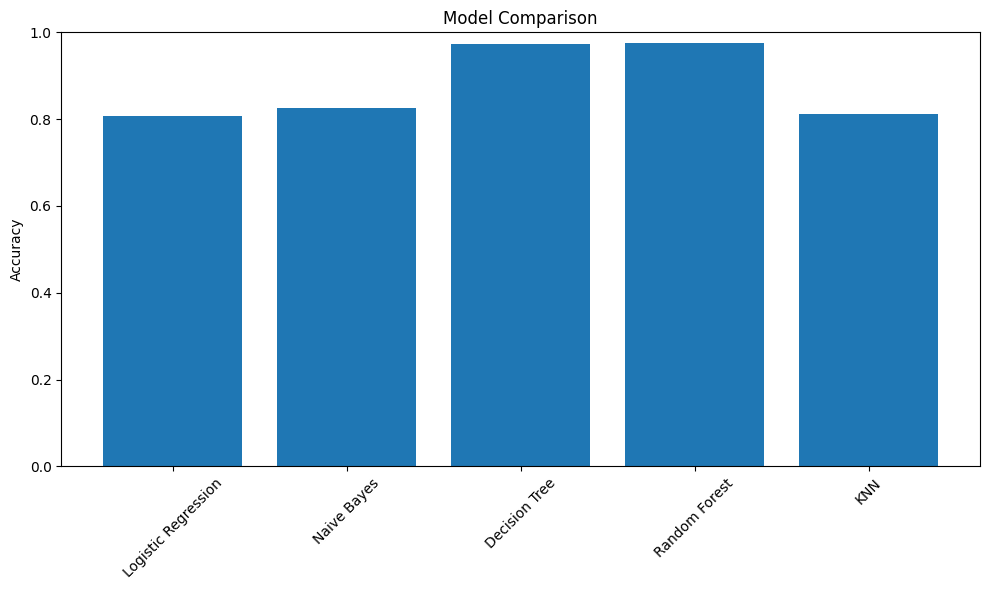

In [134]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")
print(classification_report(y_test, log_reg_pred))

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(classification_report(y_test, nb_pred))

# 3. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(classification_report(y_test, dt_pred))

# 4. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_pred))

# 5. KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(classification_report(y_test, knn_pred))

# 6. K-Means Clustering
# Since K-means is an unsupervised learning algorithm, we'll implement it slightly differently
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming binary classification
kmeans.fit(x)
kmeans_labels = kmeans.labels_

# Compare with actual labels (this is just for evaluation since K-means is unsupervised)
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y, kmeans_labels)
print(f"K-means Adjusted Rand Index: {ari:.4f}")

# Visualize K-means clusters (if dataset is 2D or can be reduced to 2D)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

plt.figure(figsize=(10, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=100)
plt.title('K-means Clustering (PCA-reduced data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Compare models
models = {
    'Logistic Regression': log_reg_accuracy,
    'Naive Bayes': nb_accuracy,
    'Decision Tree': dt_accuracy,
    'Random Forest': rf_accuracy,
    'KNN': knn_accuracy
}

plt.figure(figsize=(10, 6))
plt.bar(models.keys(), models.values())
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [135]:
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"K-means Adjusted Rand Index: {ari:.4f}")

Logistic Regression Accuracy: 0.8071
Naive Bayes Accuracy: 0.8268
Decision Tree Accuracy: 0.9724
Random Forest Accuracy: 0.9764
KNN Accuracy: 0.8110
K-means Adjusted Rand Index: 0.3072
